In [4]:
import sys
import os
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
sys.path.append(os.getcwd() + '/home/hector/Documents/dynapse-se2-data/time_constant_recordings')
#start from here
data_path=('/pulse_data_core_0_coarse_0.npy')
data=np.load(data_path)



FileNotFoundError: [Errno 2] No such file or directory: '/pulse_data_core_0_coarse_0.npy'

In [ ]:

def time_constant_extraction(data, full=False, beta=1/0.26, cut_off=15, window_length=51, polyorder=3):
    raw_voltage=data[0]*1000
    raw_time=data[1]

    time_mask = raw_time >= 1.5
    time_masked = raw_time[time_mask]
    voltage_masked = raw_voltage[time_mask]

    sampling_rate = 1 / np.mean(np.diff(time_masked))  # Hz
    cutoff_freq = cut_off # Hz
    filter_order = 5
    nyquist_freq = 0.5 * sampling_rate
    cutoff_freq_normalized = cutoff_freq / nyquist_freq
    b, a = butter(filter_order, cutoff_freq_normalized, btype='low')
    voltage_filtered = filtfilt(b, a, voltage_masked)
    peak_index = np.argmax(voltage_filtered)

    # Smooth the data and take the derivative
    voltage_smooth = savgol_filter(voltage_filtered, window_length, polyorder)
    derivative = np.gradient(voltage_smooth)

    # Find the start of the decay using the derivative
    decay_start_index = None
    decay_thresholds = [-2, -1, 0.5, -0.1, -0.02, -0.01, -0.005]

    for decay_threshold in decay_thresholds:
        for index in range(peak_index, len(derivative) - 1):
            if derivative[index] < decay_threshold and derivative[index + 1] < decay_threshold:
                decay_start_index = index
                break
        if decay_start_index is not None:
            break

    if decay_start_index is None:
        # Decay not found, find index closest to 1.6 seconds
        target_time = 1.6
        closest_index = min(range(len(time_masked)), key=lambda i: abs(time_masked[i] - target_time))
        decay_start_index = closest_index

    decay_start_index += 1
    time_decay = time_masked[decay_start_index:]
    time_decay = time_decay - time_decay[0]

    I_mem = np.exp((voltage_filtered[decay_start_index:])*beta)
    I_mem = I_mem - np.mean(I_mem[-500:])

    def exp_func(t, A, tau):
        return A* np.exp(-t / tau)

    # Initial guess for the parameters (A, tau)
    initial_guess = [max(I_mem), 1]
    params, params_covariance = curve_fit(exp_func, time_decay, I_mem, p0=initial_guess)

    if full:
        graph_time_constant_analysis(params, raw_time, raw_voltage, time_masked, voltage_filtered, derivative, decay_threshold, decay_start_index, time_decay, I_mem)
    else:
        return params[1]


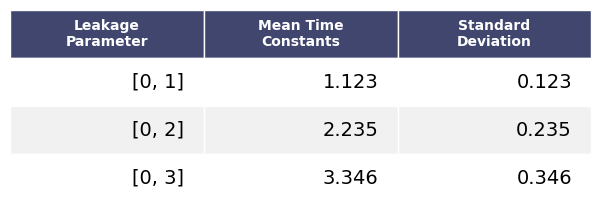

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import six
import numpy as np

data_dict = {
    'Leakage Parameter': [1, 2, 3],
    'Mean Time Constants': [1.123456, 2.234567, 3.345678],
    'Standard Deviation': [0.123456, 0.234567, 0.345678]
}

df = pd.DataFrame(data_dict)

# Round to 3 decimal places
df['Mean Time Constants'] = df['Mean Time Constants'].round(3)
df['Standard Deviation'] = df['Standard Deviation'].round(3)

# Format Leakage Parameter
df['Leakage Parameter'] = df['Leakage Parameter'].apply(lambda x: f'[0, {x}]')

# Rename columns with line breaks for text wrapping
df.columns = ['Leakage\nParameter', 'Mean Time\nConstants', 'Standard\nDeviation']

def render_mpl_table(data, col_width=3.5, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            cell.set_text_props(weight='bold', color='w', size=10) # smaller font for headers
            cell.set_facecolor(header_color)
            cell._text.set_wrap(True)  # Enable text wrapping for headers
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

fig, ax = render_mpl_table(df, header_columns=0, col_width=2.5)
fig.savefig("table.png")
